In [1]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


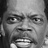

In [3]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [4]:
np.array(sample_image).shape


(48, 48)

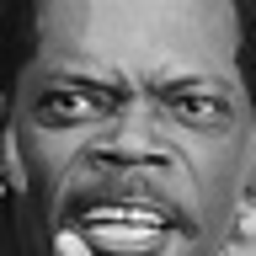

In [5]:
sample_image = sample_image.resize([256,256])
sample_image

In [6]:
np.array(sample_image).shape


(256, 256)

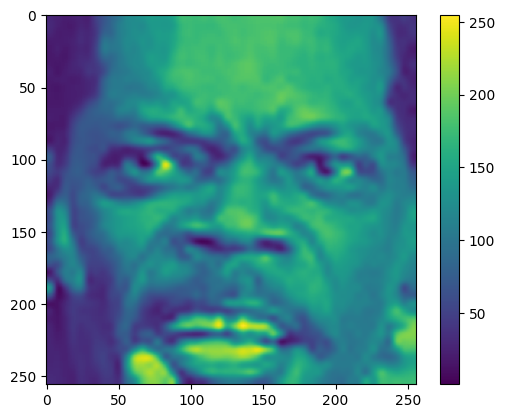

In [7]:
plt.imshow(np.array(sample_image))
plt.colorbar()

# Load Data and Extract only Face


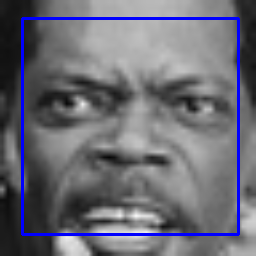

In [8]:
from google.colab.patches import cv2_imshow
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)


In [9]:
cropped_img.shape

(256, 256, 3)

In [10]:
cropped_img = cropped_img.sum(axis=2)

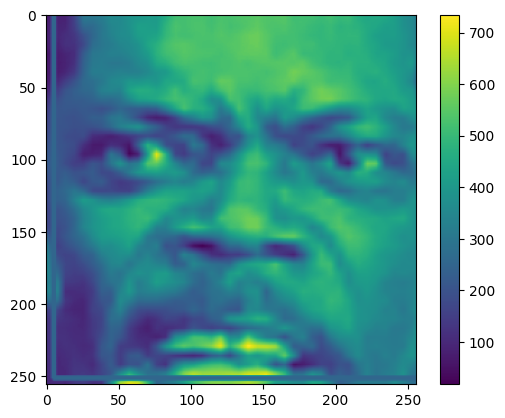

In [11]:
plt.imshow(cropped_img)
plt.colorbar()

# Load Data and Extract Only Face

In [12]:
import cv2

In [13]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [14]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

In [15]:
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'bad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [16]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(18280, 200, 200, 1) (18280, 7)
(4570, 200, 200, 1) (4570, 7)


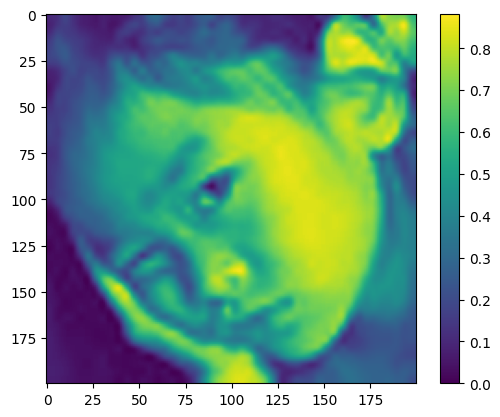

In [17]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [18]:
# train and fit a resnet50 model
resnet50_model = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [19]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [20]:
# compile the model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [21]:
n_epoch = 30
# train the model
resnet50_model.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])

Epoch 1/30
572/572 [==============================] - 215s 295ms/step - loss: 1.7311 - categorical_accuracy: 0.3122 - val_loss: 7.5079 - val_categorical_accuracy: 0.2396
Epoch 2/30
572/572 [==============================] - 165s 289ms/step - loss: 1.3812 - categorical_accuracy: 0.4595 - val_loss: 4.2683 - val_categorical_accuracy: 0.2464
Epoch 3/30
572/572 [==============================] - 165s 289ms/step - loss: 1.1961 - categorical_accuracy: 0.5394 - val_loss: 1.8605 - val_categorical_accuracy: 0.3339
Epoch 4/30
572/572 [==============================] - 165s 289ms/step - loss: 1.1198 - categorical_accuracy: 0.5710 - val_loss: 1.3733 - val_categorical_accuracy: 0.4996
Epoch 5/30
572/572 [==============================] - 165s 289ms/step - loss: 1.0432 - categorical_accuracy: 0.6038 - val_loss: 3.3491 - val_categorical_accuracy: 0.3770
Epoch 6/30
572/572 [==============================] - 165s 288ms/step - loss: 0.9938 - categorical_accuracy: 0.6239 - val_loss: 1.2104 - val_categoric

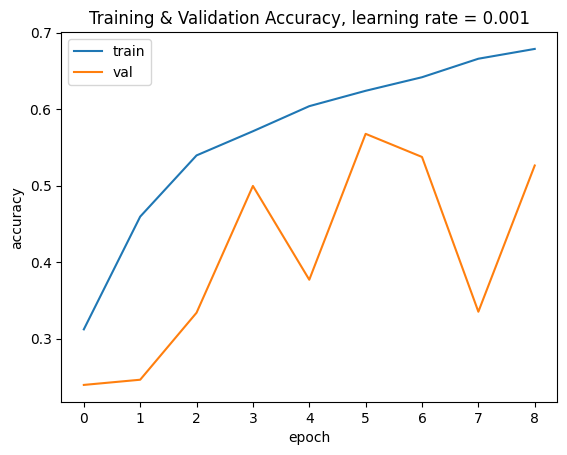

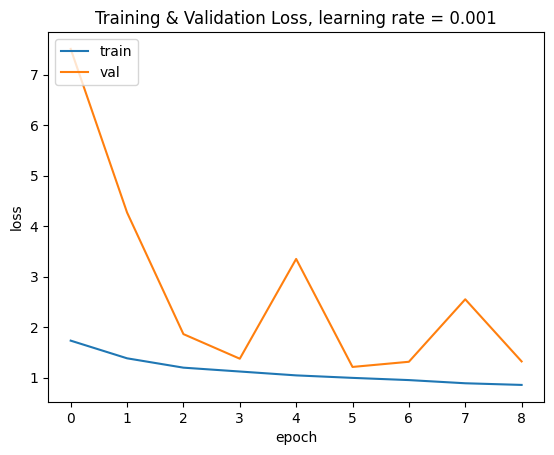

In [22]:
# save the model
resnet50_model.save('resnet50_model.h5')

# plot the accuracy and loss
plt.plot(resnet50_model.history.history['categorical_accuracy'])
plt.plot(resnet50_model.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model.history.history['loss'])
plt.plot(resnet50_model.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
resnet50_model.save('/content/gdrive/My Drive/IDS705/resnet50_model_v2')

Seems with little overfitting issue. Try batch normalisation and drop Out

## Batch Normalisation and Drop Out

In [24]:
# batch normalization and dropout
# train and fit a resnet50 model
resnet50_model_bn = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model_bn.summary()

# add batch normalization and dropout
for layer in resnet50_model_bn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss  
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor


In [26]:
n_epoch = 30
# train the model
resnet50_model_bn.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])


Epoch 1/30
572/572 [==============================] - 201s 293ms/step - loss: 1.6333 - categorical_accuracy: 0.3578 - val_loss: 3.1160 - val_categorical_accuracy: 0.1779
Epoch 2/30
572/572 [==============================] - 166s 289ms/step - loss: 1.2753 - categorical_accuracy: 0.5002 - val_loss: 3.3808 - val_categorical_accuracy: 0.2077
Epoch 3/30
572/572 [==============================] - 165s 289ms/step - loss: 1.1545 - categorical_accuracy: 0.5567 - val_loss: 1.6194 - val_categorical_accuracy: 0.4193
Epoch 4/30
572/572 [==============================] - 165s 289ms/step - loss: 1.0715 - categorical_accuracy: 0.5924 - val_loss: 1.1748 - val_categorical_accuracy: 0.5396
Epoch 5/30
572/572 [==============================] - 165s 289ms/step - loss: 1.0219 - categorical_accuracy: 0.6117 - val_loss: 1.1327 - val_categorical_accuracy: 0.5615
Epoch 6/30
572/572 [==============================] - 165s 289ms/step - loss: 0.9569 - categorical_accuracy: 0.6367 - val_loss: 1.4451 - val_categoric

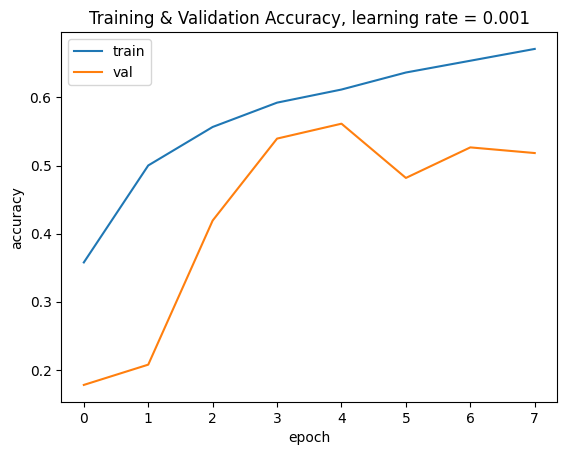

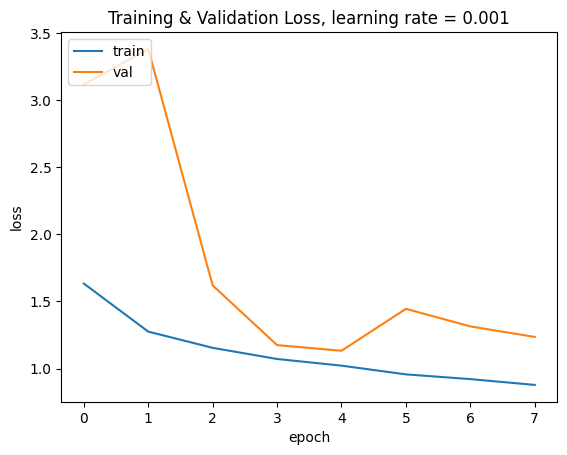

In [27]:
# plot the accuracy and loss
plt.plot(resnet50_model_bn.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bn.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bn.history.history['loss'])
plt.plot(resnet50_model_bn.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# save the model
resnet50_model_bn.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_v2')

# Test the Model

In [43]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

(5400, 200, 200, 1) (5400, 7)


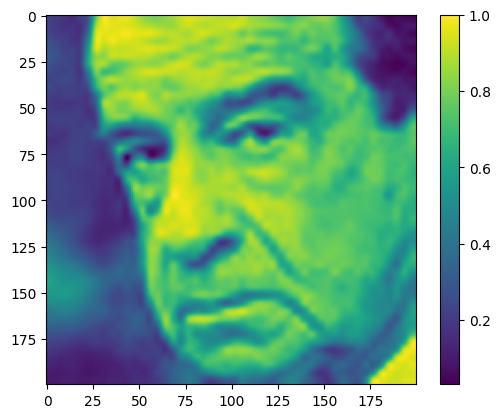

In [44]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)
y_test = np.eye(len(emo_types))[y_test]

print(x_test.shape, y_test.shape)

plt.imshow(x_test[0,:,:,0])
plt.colorbar()

In [47]:
# Evaluate the model
loss, acc = resnet50_model_bn.evaluate(x_test, y_test, verbose=2)
print("Resnet50 model, accuracy: {:5.2f}%".format(100 * acc))

169/169 - 13s - loss: 1.2168 - categorical_accuracy: 0.5361 - 13s/epoch - 78ms/step
Resnet50 model, accuracy: 53.61%


In [48]:
y_pred = resnet50_model_bn.predict(x_test, verbose=2)


169/169 - 13s - 13s/epoch - 77ms/step


In [49]:
y_pred

array([[2.3618554e-01, 3.6604889e-02, 1.7046148e-01, ..., 5.4694200e-01,
        6.1498113e-06, 3.5580925e-03],
       [5.1529121e-01, 5.5544112e-02, 1.8161891e-01, ..., 2.4144375e-01,
        1.3708840e-05, 2.7514661e-03],
       [4.3195900e-01, 2.3528056e-02, 4.6135166e-01, ..., 5.1192483e-03,
        3.9713022e-08, 3.2541133e-02],
       ...,
       [6.5567166e-02, 9.8012108e-03, 4.1105381e-01, ..., 2.1642644e-02,
        3.4234392e-06, 4.8880020e-01],
       [4.7526079e-01, 6.7008369e-02, 2.2027406e-01, ..., 2.1145566e-01,
        7.8283236e-05, 1.2603009e-02],
       [3.6688659e-02, 1.0893137e-02, 2.4527510e-01, ..., 1.9535596e-02,
        2.0575599e-06, 6.8649960e-01]], dtype=float32)

In [50]:
y_pred = np.argmax(y_pred,axis = 1)


In [51]:
y_pred


array([4, 0, 2, ..., 6, 0, 6])

In [52]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [53]:
y_test = np.argmax(y_test,axis = 1)
y_test


array([0, 0, 0, ..., 6, 6, 6])

In [54]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report


In [56]:
print(classification_report(y_test,y_pred, zero_division=1))


              precision    recall  f1-score   support

           0       0.53      0.34      0.41       888
           1       1.00      0.00      0.00        83
           2       0.33      0.55      0.41       916
           3       0.94      0.53      0.68      1752
           4       0.45      0.72      0.55      1181
           6       0.74      0.55      0.63       580

    accuracy                           0.54      5400
   macro avg       0.66      0.45      0.45      5400
weighted avg       0.64      0.54      0.55      5400

